# F3 Data Block Inference

Using SFD-CNN to infer F3 data block with segyio.

In [1]:
import segyio
from pathlib import PurePath
import numpy as np

input_path = PurePath('data', 'f3_8bit.segy')

# Loading Data
data = segyio.tools.cube(str(input_path))
data = np.moveaxis(data, -1, 0)
data = np.ascontiguousarray(data,'float32')

Display similar slice to other F3 notebook:

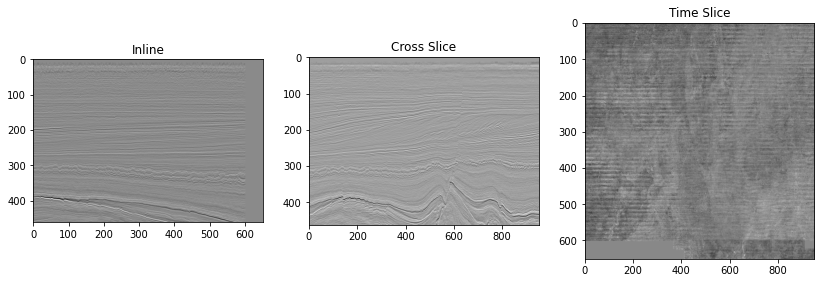

In [2]:
import matplotlib.pyplot as plt

k1,k2,k3 = 40,200,50
gx1 = data[k1,:,:]
gx2 = data[:,k2,:]
gx3 = data[:,:,k3]

#Inline slice
fig = plt.figure(figsize=(14,12))
p1 = plt.subplot(1, 3, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
plt.title("Inline")

#Crossline slice
p1 = plt.subplot(1, 3, 2)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.title("Cross Slice")

#Time slice
p1 = plt.subplot(1, 3, 3)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.title("Time Slice")
plt.show()

In [3]:
gx2.shape

(462, 951)

Processing patches of data

In [4]:
from classifier import reset_keras
from preprocessor import processPatches
from skimage.filters import gaussian

Using TensorFlow backend.


In [5]:
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

def clip(data, min=-6000, max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

In [6]:
preprocess = lambda x: myNormalization(clip(myGaussSmooth(x)))
input_data = preprocess(gx2)

/home/sdp/anaconda3/envs/os_env/lib/python3.6/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


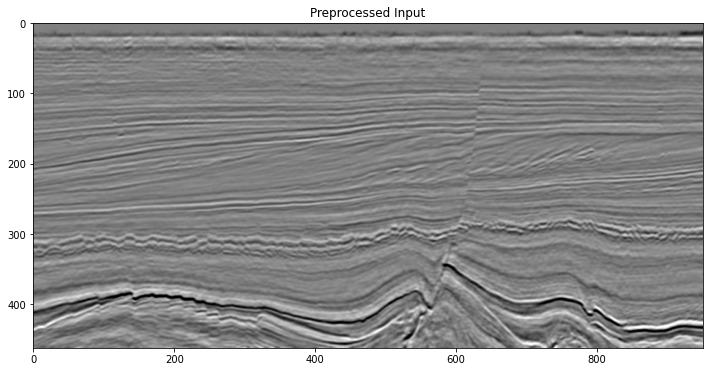

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(input_data, cmap=plt.cm.gray)
plt.title("Preprocessed Input")
plt.show()

In [8]:
input_data.max(), input_data.min()

(1.0, -1.0)

Conducting inference.

In [20]:
from keras import backend as K
# K.set_image_dim_ordering('tf')
K.set_image_data_format('channels_last')

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
K.set_session(tf.Session(config=config))

import gc
import cv2, os, numpy, sys
import pandas as pd
import multiprocessing
import time

from keras.models import model_from_json, Sequential
from joblib import Parallel, delayed
from tqdm import tqdm

# Loading Model
mlpModel = 'models/mlp.json'
mlpWeights = 'models/mlp.h5'

jsonModelFilePath = mlpModel
weightsFilePath = mlpWeights

jsonModelFile = open(jsonModelFilePath, 'r' )
base_model = jsonModelFile.read()
jsonModelFile.close()
model = model_from_json(base_model)
model.load_weights(weightsFilePath)
model.compile( 
    loss='binary_crossentropy', optimizer='sgd', metrics=[ 'accuracy' ] )

# Global Variables
patch_size = 20
patch_resize = 45
pixel_step = 1

# Preprocess variables
resize = patch_resize
imageChannels = 1
df_list = [input_data]
s = 0
nb_section = len(df_list)
section_step = 1

# Emulating Inner loop
s_init = s
df_sub_list = df_list[s:s+section_step]
s = s + section_step

num_cores = multiprocessing.cpu_count()
# results = Parallel(n_jobs=num_cores, verbose = 100)(
#     delayed(processPatches)(
#         i,  patch_size, pixel_step, resize, imageChannels
#     ) for i in df_sub_list)
results = [
    processPatches(
        i, patch_size, pixel_step, resize, imageChannels
    ) for i in df_sub_list]
current_sections_patch_lists, current_sections_patch_name_lists = zip(*results)

# classify and save
current_sections_prediction_lists = []
for i in range(0, len(current_sections_patch_lists)):
    print("Classifying section " + str(s_init + i + 1) + "/" + str(nb_section))
    patch_list = current_sections_patch_lists[i]
    patches = numpy.array( patch_list )
    patches = patches.reshape( patches.shape[0], resize, resize, imageChannels)
    patches = patches.astype( 'float32' )
    # classify
    # classesPredictionList = []
    # classesPredictionList = model.predict_classes(patches)
    
    classesPredictionList = []
    new_batch = 1000
    for i_patch in tqdm(range(0, patches.shape[0], new_batch)):
        inputs = np.zeros((new_batch, resize, resize, imageChannels))
        limit = min(new_batch, patches.shape[0] - i_patch)
        inputs[0:limit, :, :, :] = np.array(
            patches[i_patch:i_patch + limit, :, :, :],
            copy=True)
        preds = model.predict_classes(inputs)
        preds = preds.tolist()[:limit]
        classesPredictionList += preds

    current_sections_prediction_lists.append(classesPredictionList)

  1%|          | 2431/195364 [00:00<00:07, 24305.62it/s]

[Processing Patches] data.shape[0] = 462
[Processing Patches] data.shape[1] = 951


411502it [00:17, 23807.61it/s]                            


Classifying section 1/1


100%|██████████| 412/412 [01:13<00:00,  5.57it/s]


In [21]:
print("Writing classification files...")
df_names = ['f3_test_slice']
for i in range(0, len(current_sections_patch_lists)):
    print("Section " + df_names[s_init + i])
    predictionsFile = open(f'test_f3_output/batch_keras_{i}.txt', 'w')
    for j in range(0, len(current_sections_prediction_lists[i])):
        patch_name = current_sections_patch_name_lists[i][j]
        prediction = current_sections_prediction_lists[i][j]
        predictionsFile.write( patch_name + " " + str(prediction) + "\n" )
    predictionsFile.close()

Writing classification files...
Section f3_test_slice


Visualizing output

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

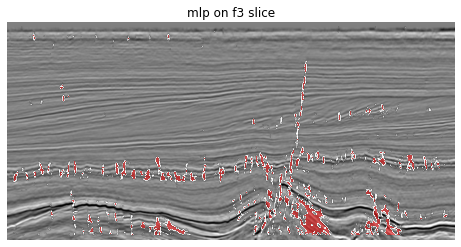

In [22]:
mask = np.zeros(input_data.shape)
classification = open('test_f3_output/batch_keras_0.txt', 'r')
for line in classification:
    if int(line.split()[1]) == 1:
        patch = line.split()[0]
        x = int(patch.split("_")[2])
        y = int(patch.split("_")[3].split(".")[0])
        mask[x,y] = 1

plt.figure(figsize=(9,4))
plt.title('mlp on f3 slice')
plt.axis('off')
plt.imshow(input_data, cmap="gray")
plt.imshow(mask, cmap="faults")